<a href="https://colab.research.google.com/github/thhtruc/NeuralNetwork/blob/main/MNIST_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The process will broken down into the following steps:
1. loading and visualize the data
2. define a neural network
3. train model
4. evaluate the performance of trained model on test dataset

In [1]:
"""Train an MLP to classify images from the MNIST database."""
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
batch_size = 20
valid_size = 0.2

# convert data to torch.FloatTensor
transforms = transforms.ToTensor()
train_data = datasets.MNIST(
    root="train_data_MNIST", train=True, download=True, transform=transforms
)
test_data = datasets.MNIST(
    root="test_data_MNIST", train=False, download=True, transform=transforms
)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting train_data_MNIST/MNIST/raw/train-images-idx3-ubyte.gz to train_data_MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting train_data_MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to train_data_MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting train_data_MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to train_data_MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting train_data_MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_data_MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting test_data_MNIST/MNIST/raw/train-images-idx3-ubyte.gz to test_data_MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting test_data_MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to test_data_MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting test_data_MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to test_data_MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting test_data_MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_data_MNIST/MNIST/raw



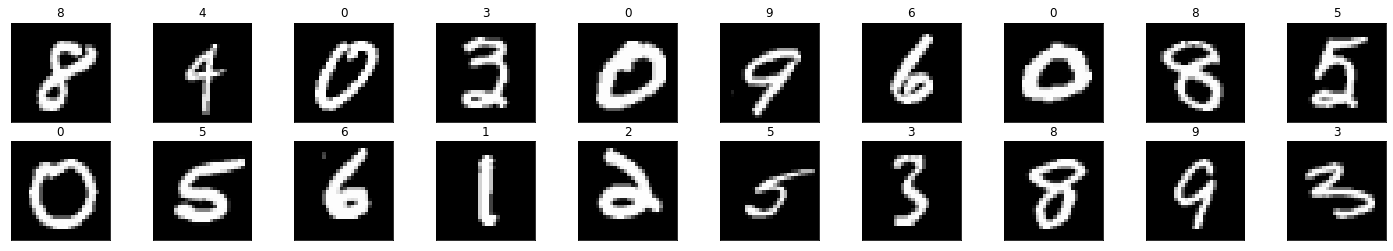

In [3]:
# visualize a batch of training data
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()


fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap="gray")
    ax.set_title(str(labels[idx].item()))
    img = np.squeeze(images[1])
plt.show()

In [4]:
class MLP(nn.Module):
    """define the MLP."""
    def __init__(self, hidden_layers, dropout=0.5):
        super(MLP, self).__init__()
        hidden_1 = hidden_layers[0]
        hidden_2 = hidden_layers[1]
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [5]:
# initialize the MLP
model = MLP(hidden_layers=[512, 256])
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [9]:
import time


tic = time.time()
epochs = 10
train_losses, valid_losses = [], []
for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0

    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss/len(train_loader.sampler)
    train_losses.append(train_loss)

    model.eval() # prep model for evaluation
    for images, labels in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        loss = criterion(output, labels)
        # update running validation loss 
        valid_loss += loss.item()
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_losses.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))

toc = time.time()
print("Time:", 1000000*(toc-tic), "s")

Epoch: 1 	Training Loss: 0.004287 	Validation Loss: 0.003951
Epoch: 2 	Training Loss: 0.004047 	Validation Loss: 0.003866
Epoch: 3 	Training Loss: 0.003988 	Validation Loss: 0.003767
Epoch: 4 	Training Loss: 0.003805 	Validation Loss: 0.003732
Epoch: 5 	Training Loss: 0.003661 	Validation Loss: 0.003638
Epoch: 6 	Training Loss: 0.003515 	Validation Loss: 0.003573
Epoch: 7 	Training Loss: 0.003479 	Validation Loss: 0.003558
Epoch: 8 	Training Loss: 0.003323 	Validation Loss: 0.003565
Epoch: 9 	Training Loss: 0.003173 	Validation Loss: 0.003511
Epoch: 10 	Training Loss: 0.003185 	Validation Loss: 0.003458
Time: 135552317.61932373 s


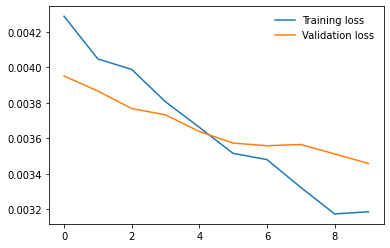

In [10]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [7]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.005466

Test Accuracy of     0: 98% (969/980)
Test Accuracy of     1: 98% (1120/1135)
Test Accuracy of     2: 96% (996/1032)
Test Accuracy of     3: 95% (961/1010)
Test Accuracy of     4: 96% (951/982)
Test Accuracy of     5: 95% (852/892)
Test Accuracy of     6: 97% (930/958)
Test Accuracy of     7: 96% (994/1028)
Test Accuracy of     8: 95% (928/974)
Test Accuracy of     9: 94% (952/1009)

Test Accuracy (Overall): 96% (9653/10000)
